In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import FactorAnalysis
import numpy as np
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
import optuna

In [2]:
df = pd.read_csv('datasets\cleaned_data_QS.csv', encoding='latin1')
score_columns = [col for col in df.columns if 'SCORE' in col]

# select lower missing-value ratio as features(used in model)
features = ['CS', 'CF', 'RI', 'Age', 'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE','IF_SCORE','IS_SCORE','Overall']
targets = ['IRN_SCORE', 'EO_SCORE', 'S_SCORE']

# Fill missing values with institution-specific mean
def fill_na_with_institution_mean(df, column):
    return df[column].fillna(df.groupby('Institution Name')[column].transform('mean'))

# If still missing, filling with country-specific mean
def fill_na_with_country_mean(df, column):
    return df[column].fillna(df.groupby('Country')[column].transform('mean'))

# Fill initial columns with country mean
cols_to_exclude = ['Institution Name', 'Country']
for col in features:
    if col not in cols_to_exclude:
        df[col] = fill_na_with_institution_mean(df, col)
        df[col] = fill_na_with_country_mean(df, col)

# Check missing
missing = df[df.columns].isnull().sum().values / df.shape[0]   # Calculate missing values ratio
for i,column in zip(missing, df.columns):
    print(f"{i * 100:.2f}% missing in",column)

0.00% missing in Rank
0.00% missing in Institution Name
0.00% missing in Country
0.00% missing in Year
0.00% missing in CS
0.00% missing in CF
0.00% missing in RI
0.24% missing in Age
0.13% missing in STA
0.02% missing in AR_SCORE
0.02% missing in ER_SCORE
0.02% missing in FS_SCORE
0.02% missing in CPF_SCORE
0.11% missing in IF_SCORE
0.13% missing in IS_SCORE
44.60% missing in IRN_SCORE
44.56% missing in EO_SCORE
58.96% missing in S_SCORE
4.13% missing in Overall


In [3]:
# Combine features and targets for imputation
all_columns = features + targets
# Split data for training and testing
train_data = df[df['Year'] >= 2024].dropna(subset=all_columns)   # ensure training data are have no missing values
test_data = df[df['Year'] < 2024].dropna(subset=features)

In [4]:
test_data[features].isnull().sum()

CS           0
CF           0
RI           0
Age          0
STA          0
AR_SCORE     0
ER_SCORE     0
FS_SCORE     0
CPF_SCORE    0
IF_SCORE     0
IS_SCORE     0
Overall      0
dtype: int64

In [5]:
for target in targets:
    X_train = train_data[features]
    y_train = train_data[target]

    model = BayesianRidge()
    model.fit(X_train, y_train)

    X_test = test_data[features]
    test_data.loc[:, target] = model.predict(X_test)

In [6]:
combined_data = pd.concat([test_data, train_data])
combined_data = combined_data.dropna(subset=all_columns) 
combined_data.to_csv('datasets\imputed_data_QS_Bayes.csv', index=False)

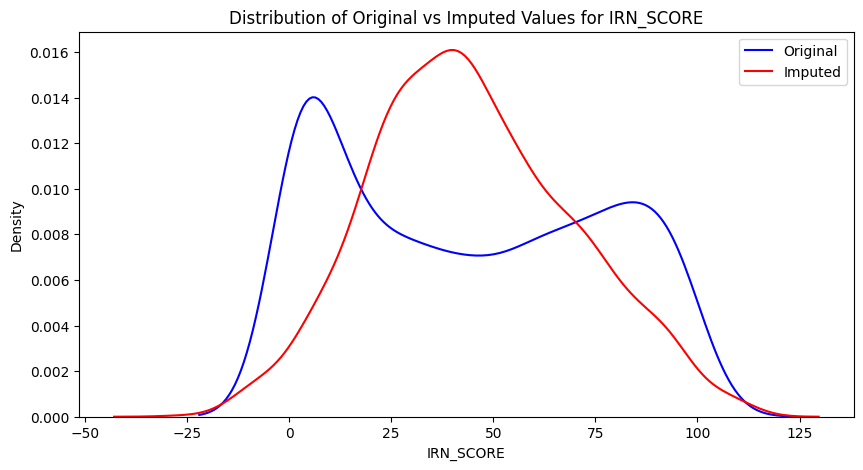

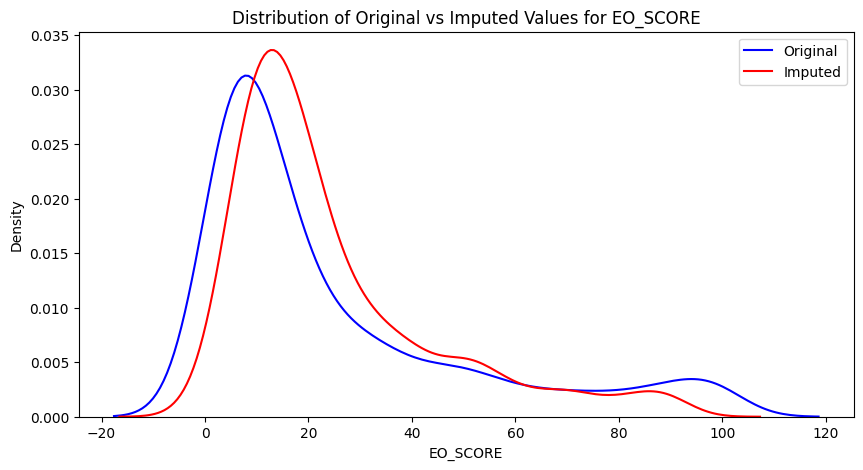

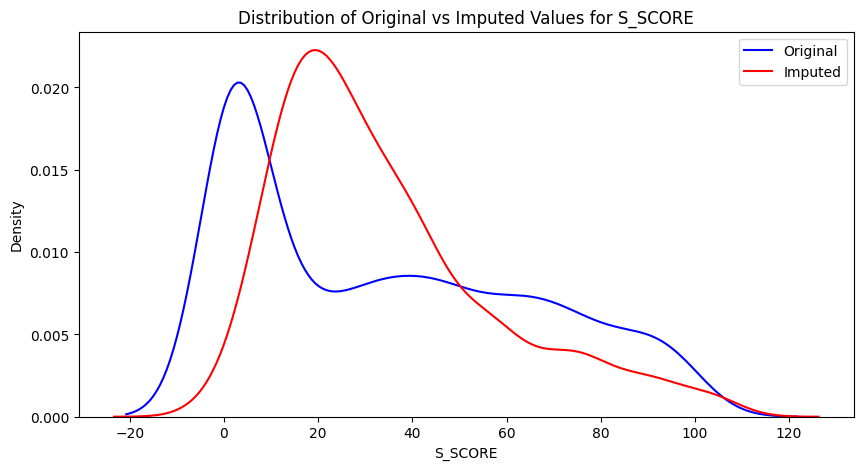

      target       R^2       RMSE        MAE
0  IRN_SCORE  0.584118  21.170273  16.887451
1   EO_SCORE  0.595426  16.876296  11.604446
2    S_SCORE  0.567608  20.409845  16.882488


In [7]:
synthetic_data = train_data.copy()
for target in targets:
    mask = synthetic_data[target].notna()
    n_to_remove = int(0.35 * mask.sum())
    indices_to_nan = np.random.choice(synthetic_data[mask].index, n_to_remove, replace=False)
    synthetic_data.loc[indices_to_nan, target] = np.nan

# 模型评估
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

for target in targets:
    train_synthetic = synthetic_data[synthetic_data[target].notna()]
    test_synthetic = synthetic_data[synthetic_data[target].isna()]

    X_train = train_synthetic[features]
    y_train = train_synthetic[target]
    X_test = test_synthetic[features]
    y_true = train_data.loc[test_synthetic.index, target]

    model = BayesianRidge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    metrics['target'].append(target)
    metrics['R^2'].append(r2)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)

    # 绘制真实 vs 预测值的分布对比图
    # Plot distribution comparison
    plt.figure(figsize=(10, 5))
    sns.kdeplot(y_true, label='Original', color='blue')
    sns.kdeplot(y_pred, label='Imputed', color='red')
    plt.title(f"Distribution of Original vs Imputed Values for {target}")
    plt.xlabel(target)
    plt.legend()
    plt.show()
    
metrics_df = pd.DataFrame(metrics)
print(metrics_df)